# <center>组分析过程</center>

In [1]:
import sys
sys.path.append('/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages')
import os
import numpy as np
import pandas as pd
from glob import glob
from bids import BIDSLayout
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.image import mean_img
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain, plot_design_matrix, plot_contrast_matrix

/home/hcp/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
def build_Subs():
    path = '/mnt/sdb1/Judge-fMRI/Data/AnalysisData/Information_of_trials.txt'
    with open(path, 'r', encoding='utf-8') as f:
        f_data = f.read().split('\n')
        data = f_data[3:]
        judge_subs = f_data[1].split(',')
        layperson_subs = f_data[2].split(',')

    build_subs_dict = {}
    for i in data:
        li = i.split(',')
        build_subs_dict[li[0]] = []
        for j in range(int((len(li)-1)/2)):
            build_subs_dict[li[0]].append([li[2*j+1], li[(j+1)*2]])

    return judge_subs, layperson_subs, build_subs_dict

judge_subs, layperson_subs, build_subs_dict = build_Subs()
print(judge_subs)
print(layperson_subs)

['001', '002', '003', '005', '006', '007', '008', '009', '010', '014', '015', '019', '022', '023', '024', '025']
['031', '033', '034', '035', '038', '042', '044', '046', '047', '050', '051', '053']


# <center>目录</center>
# 1 配对t检验
## ——1.1输入数据
## ——1.2设计矩阵
## ——1.3二阶模型
## ——1.4计算统计量z分数
## ——1.5FDR多重比较校正 & 打印坐标点

**********

### 1.1输入数据

In [4]:
outdir = '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620'
n_subjects = len(judge_subs)
moral_z_maps = sorted(glob(os.path.join(outdir, '*moral_zmap.nii.gz')))[n_subjects:]
judge_z_maps = sorted(glob(os.path.join(outdir, '*legal_zmap.nii.gz')))[n_subjects:]
print(len(moral_z_maps))
print(len(judge_z_maps))
second_level_input = moral_z_maps + judge_z_maps
second_level_input

12
12


['/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-031-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-033-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-034-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-035-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-038-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-042-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-044-moral_zmap.n

### 1.2设计矩阵

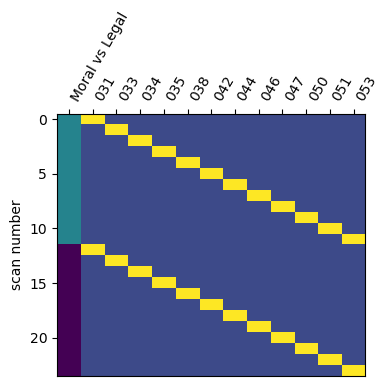

,Moral vs Legal,031,033,034,035,038,042,044,046,047,050,051,053
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
subject_effect = np.vstack((np.eye(len(layperson_subs)), np.eye(len(layperson_subs))))
condition_effect = np.hstack(([1] * len(layperson_subs), [-1] * len(layperson_subs)))

paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["Moral vs Legal"] + layperson_subs,
)
plot_design_matrix(paired_design_matrix)
plt.show()
paired_design_matrix

### 1.3二阶模型

In [6]:
second_level_model_paired = SecondLevelModel(n_jobs=4).fit(
    second_level_input, design_matrix=paired_design_matrix
)

### 1.4计算统计量——无需指定对比矩阵，仅需指定单个参数

In [7]:
z_maps_paired = second_level_model_paired.compute_contrast("Moral vs Legal", output_type="z_score")

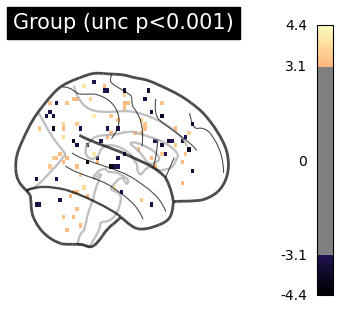

The unc threshold is 3.09


In [8]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plotting.plot_glass_brain(z_maps_paired, colorbar=True, threshold=p001_unc,
                          title='Group (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()
print(f"The unc threshold is {p001_unc:.3g}")

### 1.5三种多重比较校正 & 打印坐标点

In [9]:
thresholded_map, threshold = threshold_stats_img(
    z_maps_paired, alpha=.05, height_control='fdr', cluster_threshold=0)#00000000000000000000
print(f"The FDR=.05 threshold is {threshold:.3g}")

The FDR=.05 threshold is inf


/home/hcp/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.406236790945192. But, you have given threshold=inf.
  stat_img = threshold_img(


/home/hcp/anaconda3/lib/python3.11/site-packages/nilearn/plotting/find_cuts.py:66: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  warnings.warn(
/home/hcp/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


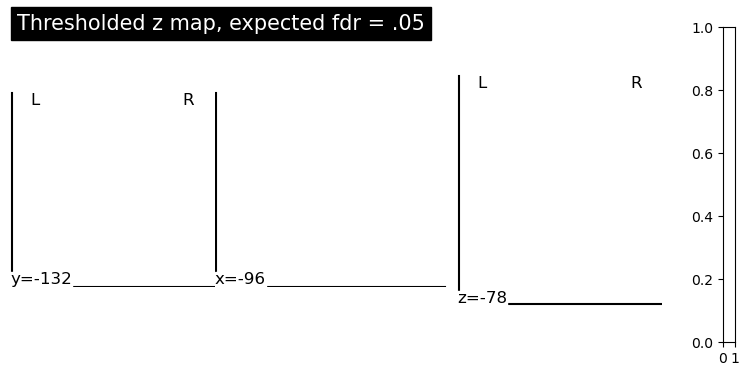

In [10]:
plotting.plot_stat_map(
    thresholded_map,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold,
)

In [11]:
table = get_clusters_table(thresholded_map, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
table

/tmp/ipykernel_1060030/3886742853.py:1: UserWarning: Attention: No clusters with stat higher than 0
  table = get_clusters_table(thresholded_map, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [11]:
name = "layperson_Moral_legal"
thresholded_map.to_filename(name + ".nii.gz")

In [12]:
table.to_csv(name + ".csv")

In [12]:
from atlasreader import create_output
create_output(name + ".nii.gz", cluster_extent=0)

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



NameError: name 'name' is not defined

In [14]:
peak_info = pd.read_csv(name + '_peaks.csv')
peak_info

FileNotFoundError: [Errno 2] No such file or directory: 'layperson_Moral_legal_peaks.csv'

In [15]:
cluster_info = pd.read_csv(name + '_clusters.csv')
cluster_info

FileNotFoundError: [Errno 2] No such file or directory: 'layperson_Moral_legal_clusters.csv'

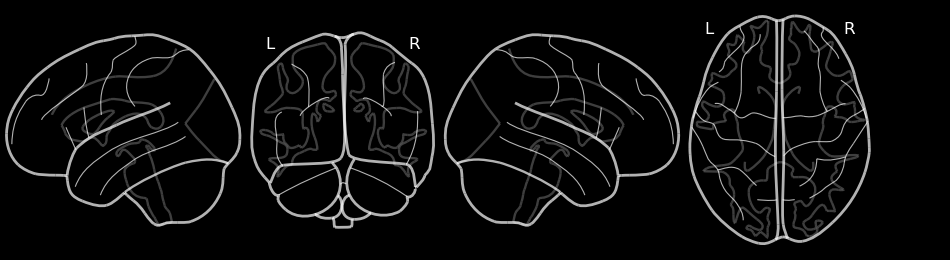

In [16]:
from IPython.display import Image
Image(name + ".png")